In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras

In [ ]:
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D
from keras.layers import Flatten
from keras.layers import Conv1D, Conv2D, Conv3D
from keras.layers import BatchNormalization
from keras.layers import Activation
from keras.layers import MaxPooling2D, AveragePooling2D
from keras.models import Model, Sequential
#from tensorflow.python.keras.optimizer_v2.adam import Adam
#from keras.optimizers import adam_v2
from tensorflow.keras.optimizers import RMSprop
#from keras.optimizers import rmsprop
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
#, SGD,RMSpro


In [ ]:
!pip install tensorflow

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ibnufjrmm","key":"9e9456e13cd493aa63f01baa6d1e5f67"}'}

In [ ]:
! pip install kaggle
! mkdir ~/.kaggle #creating a hidden directory
! cp kaggle.json ~/.kaggle/ #pasting the kaggle api token to above dir
! chmod 600 ~/.kaggle/kaggle.json ## chaging the mode for the file

In [ ]:
! kaggle datasets download deadskull7/fer2013 # downloading the datset

 92% 89.0M/96.6M [00:01<00:00, 91.7MB/s]
100% 96.6M/96.6M [00:01<00:00, 74.5MB/s]


In [ ]:
! kaggle datasets download deadskull7/fer2013 # downloading the datset

fer2013.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
! unzip /content/fer2013.zip #unzip the downloaded dataset

Archive:  /content/fer2013.zip
  inflating: fer2013.csv             


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Flatten, Dense, Dropout, Conv2D,MaxPool2D,ZeroPadding2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications import vgg16
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns

#for model deployement
import os
import cv2
import numpy as np
from tensorflow.keras.models import model_from_json
from tensorflow.keras.utils import img_to_array

In [ ]:
df = pd.read_csv('./fer2013.csv') #read dataset

df.head(5),df.shape  #first five rows and count of rows and columns

(   emotion                                             pixels     Usage
 0        0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...  Training
 1        0  151 150 147 155 148 133 111 140 170 174 182 15...  Training
 2        2  231 212 156 164 174 138 161 173 182 200 106 38...  Training
 3        4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...  Training
 4        6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...  Training,
 (35887, 3))

In [ ]:
print("Null values present in the file:",df.isna().sum().sum())
print("Basic information about the dataframe:")
df.info()

df.describe()

Null values present in the file: 0
Basic information about the dataframe:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  35887 non-null  int64 
 1   pixels   35887 non-null  object
 2   Usage    35887 non-null  object
dtypes: int64(1), object(2)
memory usage: 841.2+ KB


,emotion
count,35887.000000
mean,3.323265
std,1.873819
min,0.000000
25%,2.000000
50%,3.000000
75%,5.000000
max,6.000000


In [ ]:
emotions = { #list of available emotions in the dataset
    0:"Angry",
    1:"Disgust",
    2:"Fear",
    3:"Happy",
    4:"Sad",
    5:"Surprize",
    6:"Neutral"
}

In [ ]:
count_usage = (df.groupby(df['Usage'])['pixels'].count()).to_frame()
count_usage

,pixels
Usage,
PrivateTest,3589
PublicTest,3589
Training,28709


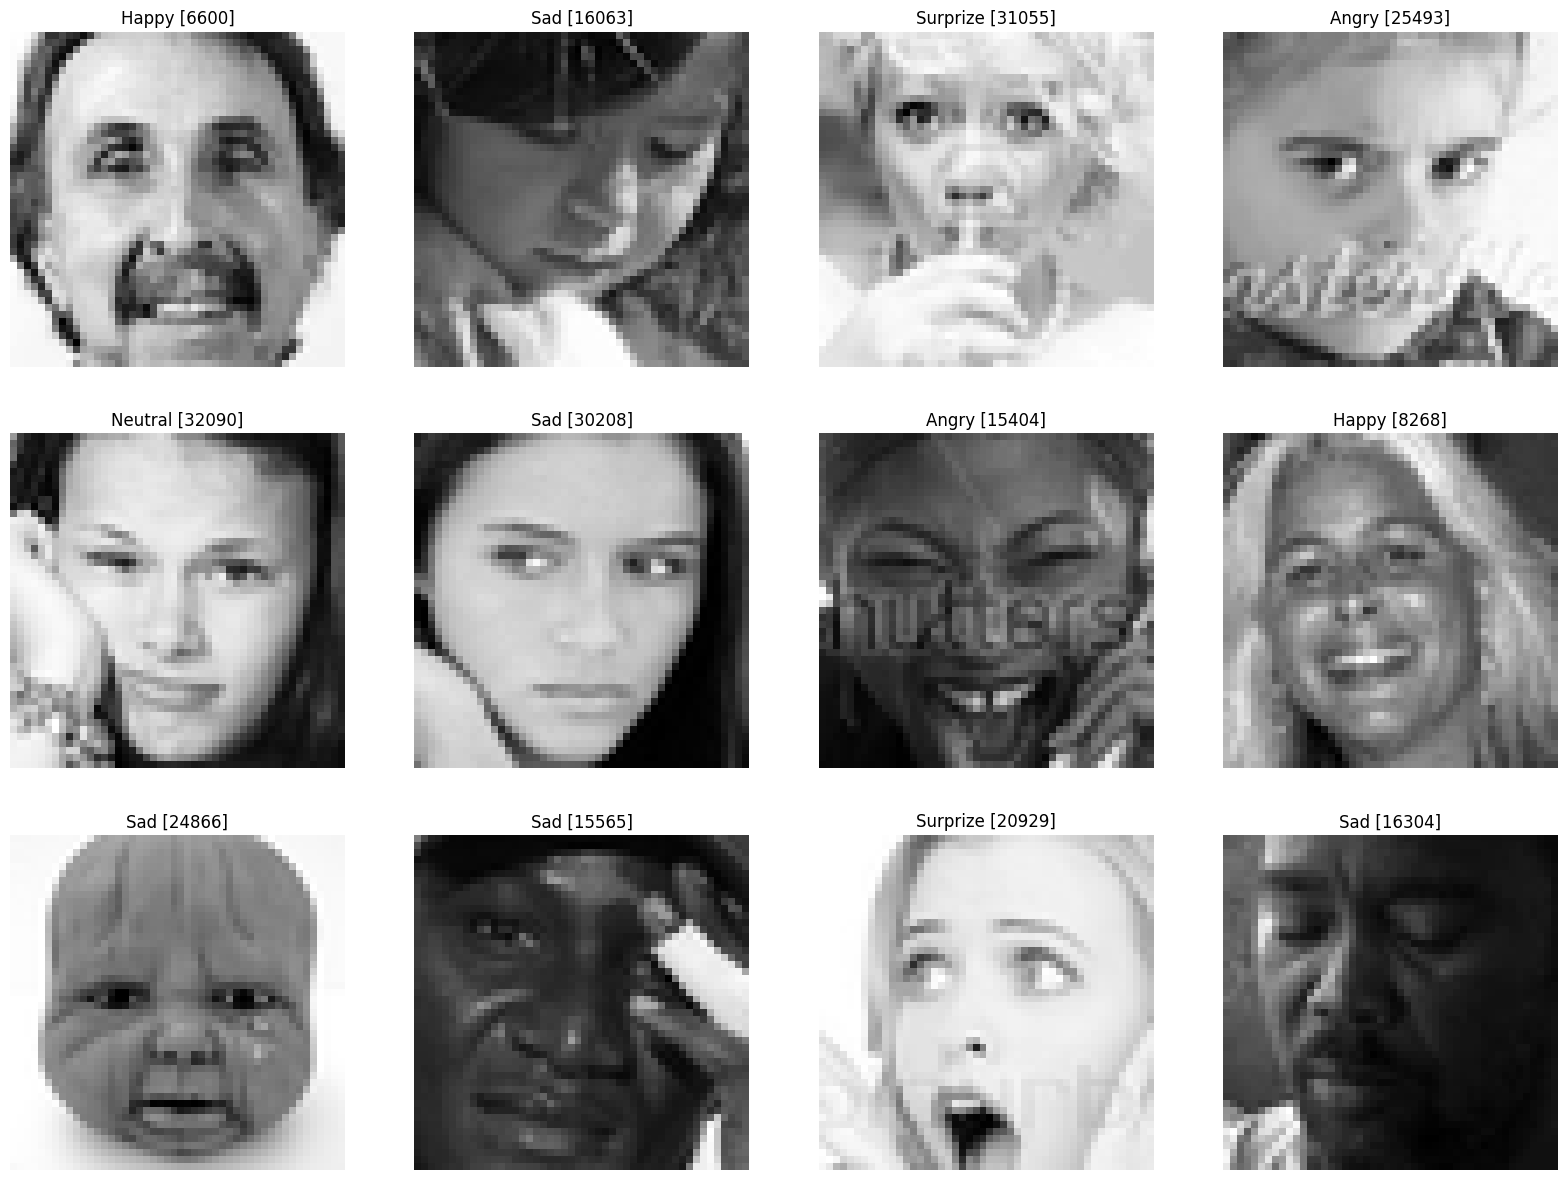

In [ ]:
# from PIL import Image
# pixels = df['pixels'][0]
# b = bytes(int(p) for p in pixels.split())
# i = Image.frombuffer('L',(48,48),b)
# di.save('a.png')
def visualize_images(n_img=4):
    indices = np.random.randint(0,df.shape[0],size=n_img)
#     print(indices)
    plt.figure(figsize=(20,20))
    for i,l in zip(indices,range(0,len(indices))):
        image_ar = np.array([i for i in  df['pixels'][i].split()] , dtype='float')
        pixels = np.reshape(image_ar,(48,48))
        ax = plt.subplot(4,4,l+1)
        plt.imshow(pixels,cmap='gray')
        plt.title(emotions[df['emotion'][i]]+" ["+str(i)+"]")
        plt.xticks()
        plt.yticks([])
        plt.axis("off")
visualize_images(12)


In [ ]:
X_train,y_train = [],[]
X_val,y_val = [],[]
X_test,y_test = [],[]
for index,row in df.iterrows():
    k = row['pixels'].split(" ")
    if row['Usage'] == 'Training':
        X_train.append(np.array(k))
        y_train.append(row['emotion'])
    elif row['Usage'] == 'PrivateTest':
        X_test.append(np.array(k))
        y_test.append(row['emotion'])
    elif row['Usage'] == 'PublicTest':
        X_val.append(np.array(k))
        y_val.append(row['emotion'])

X_train = np.array(X_train,dtype='float')
y_train = np.array(y_train)
X_test = np.array(X_test,dtype='float')
y_test = np.array(y_test)
X_val = np.array(X_val,dtype='float')
y_val = np.array(y_val)

In [ ]:
X_train.shape,y_train.shape,X_test.shape,y_test.shape,X_val.shape,y_val.shape

((28709, 2304), (28709,), (3589, 2304), (3589,), (3589, 2304), (3589,))

In [ ]:
X_train = X_train.reshape(X_train.shape[0],48,48,1)
X_test = X_test.reshape(X_test.shape[0],48,48,1)
X_val = X_val.reshape(X_val.shape[0],48,48,1)

y_train = to_categorical(y_train,num_classes=7)
y_test = to_categorical(y_test,num_classes=7)
y_val = to_categorical(y_val,num_classes=7)

X_train.shape,y_train.shape,X_test.shape,y_test.shape,X_val.shape,y_val.shape

((28709, 48, 48, 1),
 (28709, 7),
 (3589, 48, 48, 1),
 (3589, 7),
 (3589, 48, 48, 1),
 (3589, 7))

In [ ]:
def cnn_model():
  model = Sequential()

  model.add(ZeroPadding2D((1,1),input_shape=(48,48,1),name="block1_pad1"))
  model.add(Conv2D(64, (3, 3), activation='relu',name="block1_l1"))
  model.add(ZeroPadding2D((1,1),name="block1_pad2"))
  model.add(Conv2D(64, (3, 3), activation='relu',name="block1_l2"))
  model.add(MaxPool2D((2,2), strides=(2,2),name="pool1"))

  model.add(ZeroPadding2D((1,1),name="block2_pad1"))
  model.add(Conv2D(128, (3, 3), activation='relu',name="block2_l1"))
  model.add(ZeroPadding2D((1,1),name="block2_l2"))
  model.add(Conv2D(128, (3, 3), activation='relu',name="block2_pad2"))
  model.add(MaxPool2D((2,2), strides=(2,2),name="pool2"))

  model.add(ZeroPadding2D((1,1),name="block3_pad1"))
  model.add(Conv2D(256, (3, 3), activation='relu',name="block3_l1"))
  model.add(ZeroPadding2D((1,1),name="block3_pad2"))
  model.add(Conv2D(256, (3, 3), activation='relu',name="block3_l2"))
  model.add(ZeroPadding2D((1,1),name="block3_pad3"))
  model.add(Conv2D(256, (3, 3), activation='relu',name="block3_l3"))
  model.add(MaxPool2D((2,2), strides=(2,2),name="pool3"))

  model.add(ZeroPadding2D((1,1),name="block4_pad1"))
  model.add(Conv2D(512, (3, 3), activation='relu',name="block4_l1"))
  model.add(ZeroPadding2D((1,1),name="block4_pad2"))
  model.add(Conv2D(512, (3, 3), activation='relu',name="block4_l2"))
  model.add(ZeroPadding2D((1,1),name="block4_pad3"))
  model.add(Conv2D(512, (3, 3), activation='relu',name="block4_l3"))
  model.add(MaxPool2D((2,2), strides=(2,2),name="pool4"))


  model.add(ZeroPadding2D((1,1),name="block5_pad1"))
  model.add(Conv2D(512, (3, 3), activation='relu',name="block5_l1"))
  model.add(ZeroPadding2D((1,1),name="block5_pad2"))
  model.add(Conv2D(512, (3, 3), activation='relu',name="block5_l2"))
  model.add(ZeroPadding2D((1,1), name="block5_pad3"))
  model.add(Conv2D(512, (3, 3), activation='relu',name="block5_l3"))
  model.add(MaxPool2D((2,2), strides=(2,2),name="pool5"))

  model.add(Flatten())
  model.add(Dense(4096, activation='relu',name="block6"))
  model.add(Dropout(0.5,name="drop1"))
  model.add(Dense(4096, activation='relu',name="block7"))
  model.add(Dropout(0.5,name="drop2"))
  model.add(Dense(7, activation='softmax',name="block8"))

  return model

In [ ]:
model = cnn_model()
model.compile(optimizer='sgd',loss='categorical_crossentropy',metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_pad1 (ZeroPadding2D  (None, 50, 50, 1)         0         
 )                                                               
                                                                 
 block1_l1 (Conv2D)          (None, 48, 48, 64)        640       
                                                                 
 block1_pad2 (ZeroPadding2D  (None, 50, 50, 64)        0         
 )                                                               
                                                                 
 block1_l2 (Conv2D)          (None, 48, 48, 64)        36928     
                                                                 
 pool1 (MaxPooling2D)        (None, 24, 24, 64)        0         
                                                                 
 block2_pad1 (ZeroPadding2D  (None, 26, 26, 64)        0

In [ ]:
checkpointer = [EarlyStopping(monitor = 'val_accuracy', verbose = 1,
                              restore_best_weights=True,mode="max",patience = 10),
                              ModelCheckpoint('best_model.h5',monitor="val_accuracy",verbose=1,
                              save_best_only=True,mode="max")]

history = model.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=30,
    callbacks=checkpointer,
    validation_data=(X_val,y_val)
)

Epoch 1/30
898/898 [==============================] - ETA: 0s - loss: 1.8250 - accuracy: 0.2463
Epoch 1: val_accuracy improved from -inf to 0.24937, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


898/898 [==============================] - 61s 55ms/step - loss: 1.8250 - accuracy: 0.2463 - val_loss: 1.8196 - val_accuracy: 0.2494
Epoch 2/30
897/898 [============================>.] - ETA: 0s - loss: 1.7781 - accuracy: 0.2728
Epoch 2: val_accuracy improved from 0.24937 to 0.30092, saving model to best_model.h5
898/898 [==============================] - 49s 54ms/step - loss: 1.7781 - accuracy: 0.2727 - val_loss: 1.7293 - val_accuracy: 0.3009
Epoch 3/30
897/898 [============================>.] - ETA: 0s - loss: 1.5961 - accuracy: 0.3744
Epoch 3: val_accuracy improved from 0.30092 to 0.38284, saving model to best_model.h5
898/898 [==============================] - 51s 57ms/step - loss: 1.5961 - accuracy: 0.3744 - val_loss: 1.6418 - val_accuracy: 0.3828
Epoch 4/30
897/898 [============================>.] - ETA: 0s - loss: 1.4705 - accuracy: 0.4295
Epoch 4: val_accuracy improved from 0.38284 to 0.45472, saving model to best_model.h5
898/898 [==============================] - 53s 59ms/ste

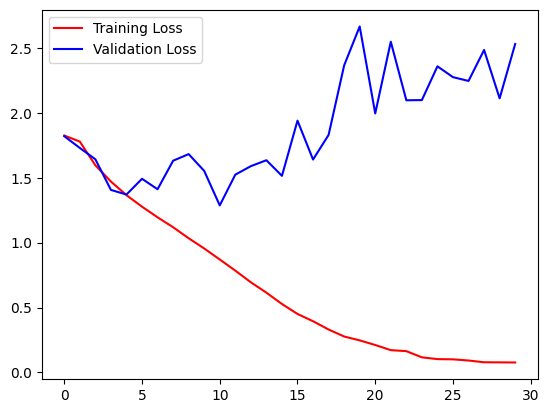

In [ ]:
def loss_plot(history):
  plt.plot(history.history["loss"],'r', label="Training Loss")
  plt.plot(history.history["val_loss"],'b', label="Validation Loss")
  plt.legend()

loss_plot(history)


In [ ]:
# Model Inference
preds = model.predict(X_test)
y_pred = np.argmax(preds , axis = 1 )


113/113 [==============================] - 2s 14ms/step


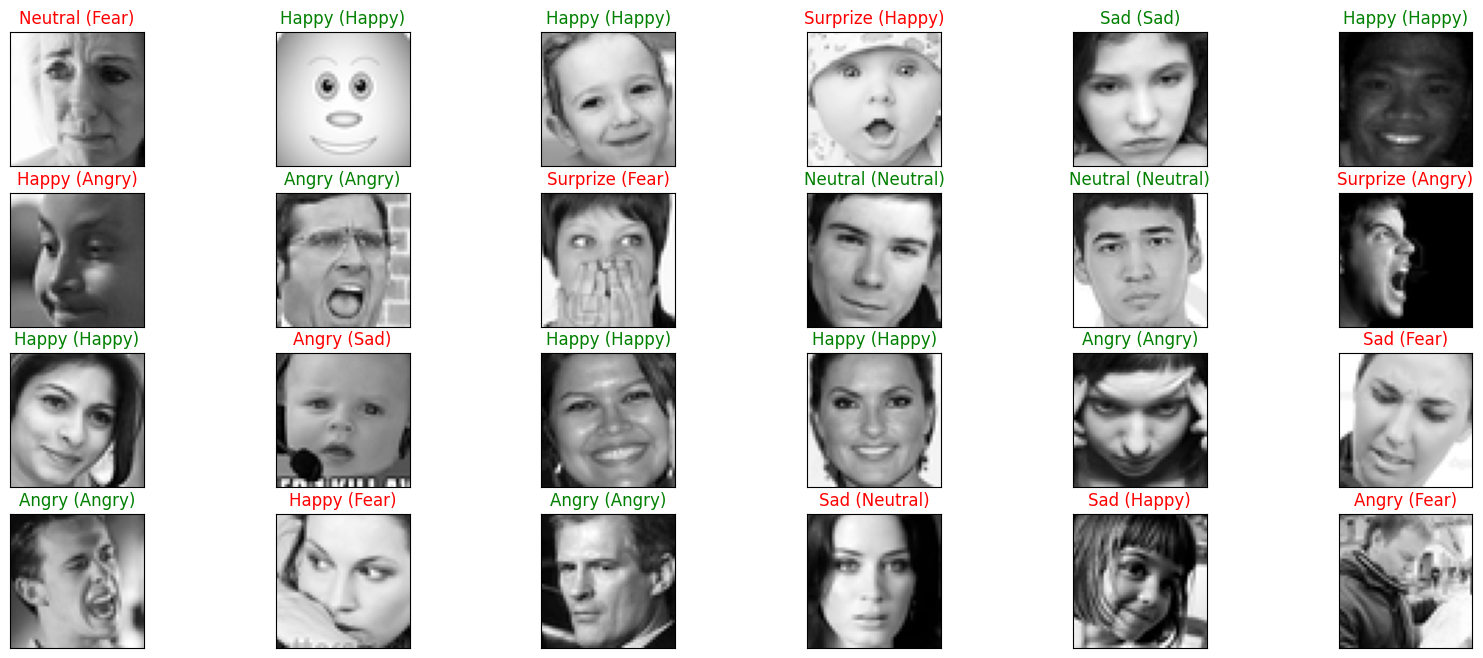

In [ ]:
#function to plot images with their lables(actual vs predicted)
def check_images(X_test,y_pred,label_dict={}):

  figure = plt.figure(figsize=(20, 8))
  for i, index in enumerate(np.random.choice(X_test.shape[0], size=24, replace=False)):
      ax = figure.add_subplot(4, 6, i + 1, xticks=[], yticks=[])
      ax.imshow(np.squeeze(X_test[index]),cmap="gray")
      predict_index = label_dict[(y_pred[index])]
      true_index = label_dict[np.argmax(y_test,axis=1)[index]]

      ax.set_title("{} ({})".format((predict_index),
                                    (true_index)),
                                    color=("green" if predict_index == true_index else "red"))
check_images(X_test,y_pred,emotions)

In [ ]:
# function to plot confusion matrix
def conf_mat(y_test,y_pred,labels=['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sadness', "Surprise"]):
  CLASS_LABELS  = labels
  cm_data = confusion_matrix(np.argmax(y_test, axis = 1 ), y_pred)
  cm = pd.DataFrame(cm_data, columns=CLASS_LABELS, index = CLASS_LABELS)
  cm.index.name = 'Actual'
  cm.columns.name = 'Predicted'
  plt.figure(figsize = (20,10))
  plt.title('Confusion Matrix', fontsize = 20)
  sns.set(font_scale=1.2)
  ax = sns.heatmap(cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g')

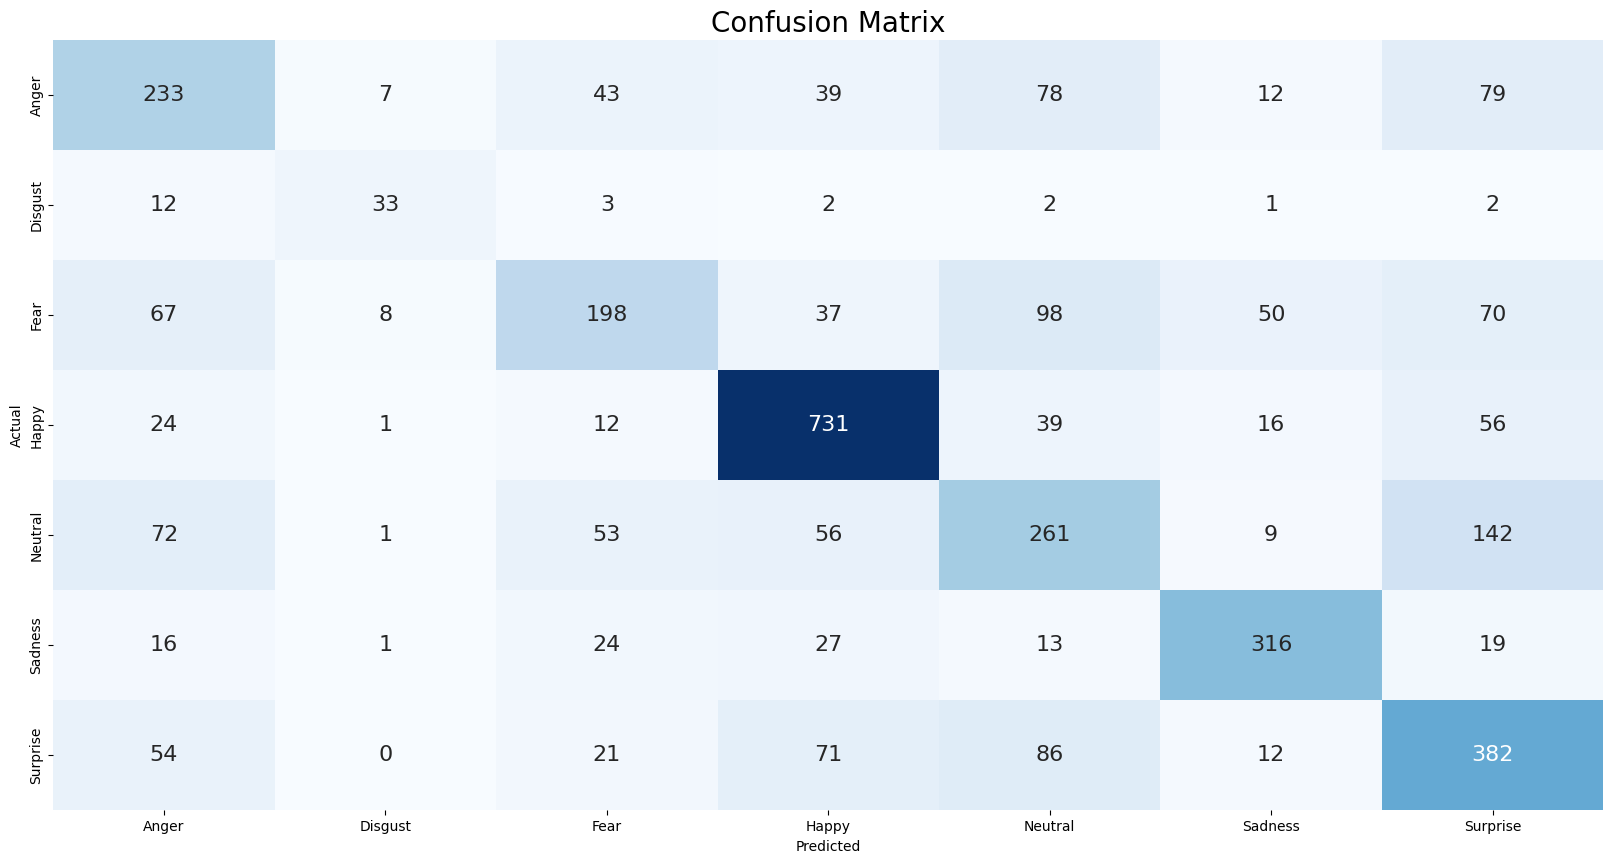

In [ ]:
conf_mat(y_test,y_pred)

In [ ]:
#classification report
print(classification_report(np.argmax(y_test, axis = 1 ),y_pred,digits=3))

              precision    recall  f1-score   support

           0      0.487     0.475     0.481       491
           1      0.647     0.600     0.623        55
           2      0.559     0.375     0.449       528
           3      0.759     0.832     0.794       879
           4      0.452     0.439     0.446       594
           5      0.760     0.760     0.760       416
           6      0.509     0.610     0.555       626

    accuracy                          0.600      3589
   macro avg      0.596     0.584     0.587      3589
weighted avg      0.597     0.600     0.594      3589



In [ ]:
 # loss and accuracy
loss_and_metrics = model.evaluate(X_train,y_train)
print("On Training Data",loss_and_metrics)

loss_and_metrics = model.evaluate(X_val,y_val)
print("On Validation Data",loss_and_metrics)

loss_and_metrics = model.evaluate(X_test,y_test)
print("On Test Data",loss_and_metrics)

898/898 [==============================] - 14s 15ms/step - loss: 0.0660 - accuracy: 0.9789
On Training Data [0.06596191227436066, 0.9788568019866943]
113/113 [==============================] - 2s 15ms/step - loss: 2.5299 - accuracy: 0.5952
On Validation Data [2.5299456119537354, 0.5951518416404724]
113/113 [==============================] - 2s 15ms/step - loss: 2.4624 - accuracy: 0.6002
On Test Data [2.462352991104126, 0.6001671552658081]


## Fine Tuning


In [ ]:
model = cnn_model()
model.compile(optimizer=SGD(learning_rate=0.005),loss='categorical_crossentropy',metrics=['accuracy'])

history = model.fit(
    X_train,
    y_train,
    batch_size=64,
    epochs=60,
    callbacks=checkpointer,
    validation_data=(X_val,y_val)
)

Epoch 1/60
449/449 [==============================] - ETA: 0s - loss: 1.8306 - accuracy: 0.2433
Epoch 1: val_accuracy did not improve from 0.59515
449/449 [==============================] - 41s 82ms/step - loss: 1.8306 - accuracy: 0.2433 - val_loss: 1.8133 - val_accuracy: 0.2494
Epoch 2/60
449/449 [==============================] - ETA: 0s - loss: 1.8107 - accuracy: 0.2503
Epoch 2: val_accuracy did not improve from 0.59515
449/449 [==============================] - 35s 79ms/step - loss: 1.8107 - accuracy: 0.2503 - val_loss: 1.7898 - val_accuracy: 0.2497
Epoch 3/60
449/449 [==============================] - ETA: 0s - loss: 1.7746 - accuracy: 0.2732
Epoch 3: val_accuracy did not improve from 0.59515
449/449 [==============================] - 35s 79ms/step - loss: 1.7746 - accuracy: 0.2732 - val_loss: 1.7248 - val_accuracy: 0.3335
Epoch 4/60
449/449 [==============================] - ETA: 0s - loss: 1.7006 - accuracy: 0.3238
Epoch 4: val_accuracy did not improve from 0.59515
449/449 [====

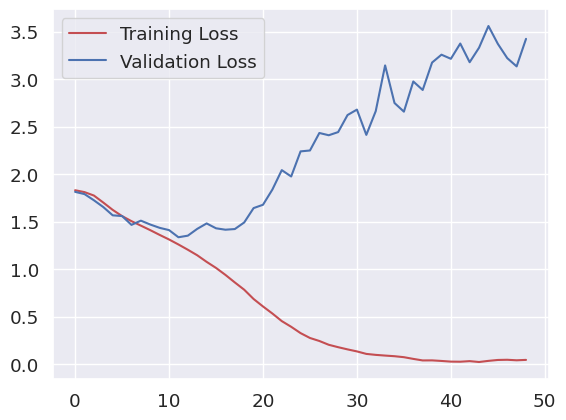

In [ ]:
loss_plot(history)


In [ ]:
preds = model.predict(X_test)
y_pred = np.argmax(preds , axis = 1 )
print(classification_report(np.argmax(y_test, axis = 1 ),y_pred,digits=3))

113/113 [==============================] - 2s 15ms/step
              precision    recall  f1-score   support

           0      0.450     0.464     0.457       491
           1      0.462     0.545     0.500        55
           2      0.461     0.413     0.436       528
           3      0.760     0.776     0.768       879
           4      0.420     0.389     0.404       594
           5      0.789     0.675     0.728       416
           6      0.483     0.572     0.524       626

    accuracy                          0.565      3589
   macro avg      0.546     0.548     0.545      3589
weighted avg      0.568     0.565     0.565      3589



## Change The optimer


In [ ]:
# loss and accuracy

model = cnn_model()
model.compile(optimizer=Adam(learning_rate=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])

history = model.fit(
    X_train,
    y_train,
    batch_size=64,
    epochs=50,
    callbacks=checkpointer,
    validation_data=(X_val,y_val)
)

Epoch 1/50
449/449 [==============================] - ETA: 0s - loss: 1.7332 - accuracy: 0.2873
Epoch 1: val_accuracy did not improve from 0.59515
449/449 [==============================] - 44s 83ms/step - loss: 1.7332 - accuracy: 0.2873 - val_loss: 1.5559 - val_accuracy: 0.3720
Epoch 2/50
449/449 [==============================] - ETA: 0s - loss: 1.4483 - accuracy: 0.4285
Epoch 2: val_accuracy did not improve from 0.59515
449/449 [==============================] - 38s 85ms/step - loss: 1.4483 - accuracy: 0.4285 - val_loss: 1.3786 - val_accuracy: 0.4583
Epoch 3/50
449/449 [==============================] - ETA: 0s - loss: 1.2956 - accuracy: 0.4953
Epoch 3: val_accuracy did not improve from 0.59515
449/449 [==============================] - 37s 82ms/step - loss: 1.2956 - accuracy: 0.4953 - val_loss: 1.3214 - val_accuracy: 0.4968
Epoch 4/50
449/449 [==============================] - ETA: 0s - loss: 1.1692 - accuracy: 0.5517
Epoch 4: val_accuracy did not improve from 0.59515
449/449 [====

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


449/449 [==============================] - 42s 94ms/step - loss: 0.1092 - accuracy: 0.9643 - val_loss: 2.1827 - val_accuracy: 0.5977
Epoch 17/50
449/449 [==============================] - ETA: 0s - loss: 0.1028 - accuracy: 0.9664
Epoch 17: val_accuracy did not improve from 0.59766
449/449 [==============================] - 36s 81ms/step - loss: 0.1028 - accuracy: 0.9664 - val_loss: 2.1827 - val_accuracy: 0.5901
Epoch 18/50
449/449 [==============================] - ETA: 0s - loss: 0.0957 - accuracy: 0.9690
Epoch 18: val_accuracy improved from 0.59766 to 0.60212, saving model to best_model.h5
449/449 [==============================] - 43s 95ms/step - loss: 0.0957 - accuracy: 0.9690 - val_loss: 1.9997 - val_accuracy: 0.6021
Epoch 19/50
449/449 [==============================] - ETA: 0s - loss: 0.0877 - accuracy: 0.9708
Epoch 19: val_accuracy did not improve from 0.60212
449/449 [==============================] - 36s 81ms/step - loss: 0.0877 - accuracy: 0.9708 - val_loss: 2.2127 - val_acc

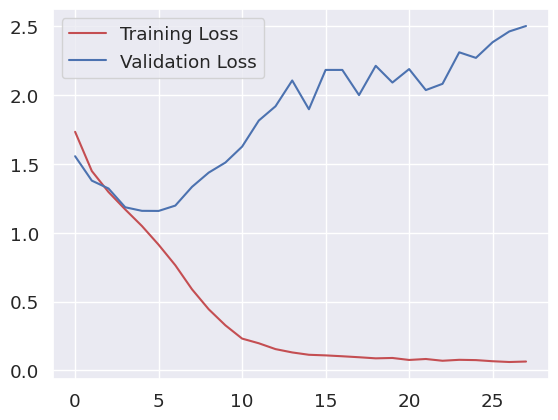

In [ ]:
loss_plot(history)

In [ ]:
print(classification_report(np.argmax(y_test, axis = 1 ),y_pred,digits=3))

              precision    recall  f1-score   support

           0      0.450     0.464     0.457       491
           1      0.462     0.545     0.500        55
           2      0.461     0.413     0.436       528
           3      0.760     0.776     0.768       879
           4      0.420     0.389     0.404       594
           5      0.789     0.675     0.728       416
           6      0.483     0.572     0.524       626

    accuracy                          0.565      3589
   macro avg      0.546     0.548     0.545      3589
weighted avg      0.568     0.565     0.565      3589



## Save Model

In [ ]:
from google.colab import files

# Simpan model dalam file "model.json"
model_json = model.to_json()
with open("model.h5", "w") as json_file:
    json_file.write(model_json)

# Download file "model.json" ke perangkat lokal Anda
files.download("model.h5")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Simpan bobot model dalam file "weights.h5"
model.save_weights("weights.h5")

# Download file "weights.h5" ke perangkat lokal Anda
files.download("weights.h5")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Ambil model dan bobot yang telah disimpan sebelumnya
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights('weights.h5')

In [ ]:
from google.colab import files

# Upload file "model.json"
uploaded = files.upload()

# Simpan file yang diupload
for name, data in uploaded.items():
    with open(name, 'wb') as f:
        f.write(data)
    print(f"File '{name}' berhasil diupload.")


# # open cv


In [ ]:
!pip install opencv-python-headless


In [ ]:
model = model_from_json(open("model.json", "r").read())
model.load_weights('best_model.h5')
face_haar_cascade = cv2.CascadeClassifier(cv2.data.haarcascades +'haarcascade_frontalface_default.xml')



In [ ]:
import cv2
import numpy as np
from keras.models import model_from_json

# Load model architecture from JSON file
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# Load model weights from H5 file
loaded_model.load_weights('model.h5')
print("Model loaded from disk.")

# Initialize face cascade classifier
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Open webcam
cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    for (x, y, w, h) in faces:
        roi_gray = gray[y:y + h, x:x + w]
        roi_gray = cv2.resize(roi_gray, (48, 48))
        roi_gray = roi_gray / 255.0
        roi_gray = np.expand_dims(np.expand_dims(roi_gray, -1), 0)

        prediction = loaded_model.predict(roi_gray)
        emotion = np.argmax(prediction)
        emotion_labels = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']
        label = emotion_labels[emotion]

        cv2.rectangle(frame, (x, y), (x + w, y + h), (255, 0, 0), 2)
        cv2.putText(frame, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2, cv2.LINE_AA)

    cv2.imshow('Face Emotion Recognition', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


OSError: ignored

In [ ]:
import cv2
import numpy as np

def run_emotion_detection():
    face_haar_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    cap = cv2.VideoCapture(0)

    while True:
        ret, test_image = cap.read()
        if not ret:
            break

        gray_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2GRAY)

        faces_detected = face_haar_cascade.detectMultiScale(gray_image)
        for (x, y, w, h) in faces_detected:
            cv2.rectangle(test_image, (x, y), (x+w, y+h), (255, 0, 0), 2)
            roi_gray = gray_image[y:y+w, x:x+h]
            roi_gray = cv2.resize(roi_gray, (48, 48))
            image_pixels = np.expand_dims(np.expand_dims(roi_gray, -1), 0)

            predictions = model.predict(image_pixels)
            max_index = np.argmax(predictions[0])

            emotion_detection = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')
            emotion_prediction = emotion_detection[max_index]

            cv2.putText(test_image, emotion_prediction, (int(x), int(y)), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 255, 0), 3)

        resized_image = cv2.resize(test_image, (1000, 700))
        cv2.imshow('Emotion Detector', resized_image)

        if cv2.waitKey(10) == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

# Memanggil fungsi untuk menjalankan deteksi ekspresi wajah secara live dari webcam
run_emotion_detection()


In [ ]:
from google.colab import output

def enable_camera():
    output.eval_js('new Promise((resolve, reject) => { navigator.mediaDevices.getUserMedia({ video: true }).then((stream) => { document.querySelector("#output-area").appendChild(Object.assign(document.createElement("video"), { srcObject: stream, controls: true })); resolve(); }).catch((err) => reject(err)); });')

enable_camera()


In [ ]:
import cv2
import numpy as np

def run_emotion_detection():
    face_haar_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    cap = cv2.VideoCapture(0)

    while True:
        ret, test_image = cap.read()
        if not ret:
            break

        gray_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2GRAY)

        faces_detected = face_haar_cascade.detectMultiScale(gray_image)
        for (x, y, w, h) in faces_detected:
            cv2.rectangle(test_image, (x, y), (x+w, y+h), (255, 0, 0), 2)
            roi_gray = gray_image[y:y+w, x:x+h]
            roi_gray = cv2.resize(roi_gray, (48, 48))
            image_pixels = np.expand_dims(np.expand_dims(roi_gray, -1), 0)

            predictions = model.predict(image_pixels)
            max_index = np.argmax(predictions[0])

            emotion_detection = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')
            emotion_prediction = emotion_detection[max_index]

            cv2.putText(test_image, emotion_prediction, (int(x), int(y)), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 255, 0), 3)

        resized_image = cv2.resize(test_image, (1000, 700))
        cv2.imshow('Emotion Detector', resized_image)

        if cv2.waitKey(10) == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

# Memanggil fungsi untuk menjalankan deteksi ekspresi wajah secara live dari webcam
run_emotion_detection()


<IPython.core.display.Javascript object>

'photo.jpg'